In [1]:
#import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
import time
from time import gmtime, strftime
import io
import threading
import re
from IPython.display import clear_output
from keras.models import model_from_json
import pickle
import operator

#Import my functions from the sentiment analysis
import IntentClassification.Intent_Classification_Lai
from IntentClassification.Intent_Classification_Lai import predictions
from IntentClassification.Intent_Classification_Lai import get_final_output

Using TensorFlow backend.


Imported dependencies.


In [2]:
def followlog(chatlog):
    chatlog.seek(0,2)
    sleeptime = 0.1
    while True:
        line = chatlog.readline()
        if not line:
            time.sleep(sleeptime)
            continue
        yield line

def processline(line):
    [date, line] = line.split("_",1)
    [timeofday, channel, text] = line.split(",",2)
    channel = channel.split("#",-1)[1]
    return [date, timeofday, channel, text]

def wordcountline(dictionary,text):
    words = re.split('\s|; |, |\*|\n|\. |\.|\r|(\?)',text)
    bannedwords = {'':True, None:True}
    words = list(set(words))
    for word in words:
        if word in bannedwords: pass
        elif word in dictionary:
            dictionary[word] += 1
        else:
            dictionary[word] = 1
    return dictionary

def animatedplot(channelnumlines, channelxs, channelys, channelsentiments):
    #organizes the plotting for many channels
    channelnumber = 0
    for channel in channelnumlines:
        # Add x and y to lists
        channelxs[channel].append(strftime("%H:%M:%S", gmtime()))#The year month date, optional,can be called here %Y-%m-%d 
        channelys[channel].append(channelnumlines[channel])
        # Limit x and y lists to 10 items
        channelxs[channel] = channelxs[channel][-10:]
        channelys[channel] = channelys[channel][-10:]
        latestchannelsentiment = max(channelsentiments[channel].items(), key=operator.itemgetter(1))[0]
        channelnumber +=1
        singleplot(channel, channelxs, channelys, latestchannelsentiment, channelnumber)#Plot the number of messages for each channel
        channelnumlines[channel]=0#Reset the number of lines for each channel
        channelsentiments[channel] = initializeintentcounter(unique_intent)#Reset channel intent
    return [channelnumlines, channelsentiments]
    
def singleplot(channel, channelxs, channelys, latestchannelsentiment, channelnumber):
    #Plots for a single channel
    # Draw x and y lists
    plt.cla()
    numchannels = len(channelnumlines)
    plt.subplot(numchannels, 1,  channelnumber)
    plt.plot(channelxs[channel], channelys[channel], marker='x')
    # Format plot
    plt.xticks(rotation=45, ha='right')
    plt.subplots_adjust(bottom=0.30)
    plt.title('Number of messages for #%s; channel sentiment: %s' % (channel, latestchannelsentiment))
    plt.ylabel('Number of messages')
    plt.xlabel('Time')
    plt.draw()
    plt.pause(0.1)
    
def initializenumlines(channel, channelnumlines, channelys, channelxs):
    channelnumlines[channel]=0
    channelys[channel]=[]
    channelxs[channel]=[]
    return [channelnumlines, channelys, channelxs]
    
def initializeintentcounter(unique_intent):
    intentdictionary = {}
    for intent in unique_intent:
        intentdictionary[intent] = 0
    return intentdictionary

def getmessagesentiment(channelsentiment, word_tokenizer, text, model, max_length, unique_intent):
    sentiment = get_final_output(predictions(word_tokenizer, text, model, max_length), unique_intent, 'classify')
    channelsentiment[sentiment] += 1#Perform an intent classification
    return channelsentiment

In [3]:
#Load chat classification model
# Model reconstruction from JSON file
with open('IntentClassification/model_architecture.json', 'r') as f1:
    model = model_from_json(f1.read())

# Load weights into the new model
model.load_weights('IntentClassification/model_weights.h5')

#Load Word Tokenizer
with open('IntentClassification/tokenizer.pickle', 'rb') as handle:
    word_tokenizer = pickle.load(handle)
    
#Load Max Length of a message
with open('IntentClassification/maxlen.txt', 'r') as f2:
    max_length = int(f2.readline())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/home/laitcl/.local/lib/python3.6/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


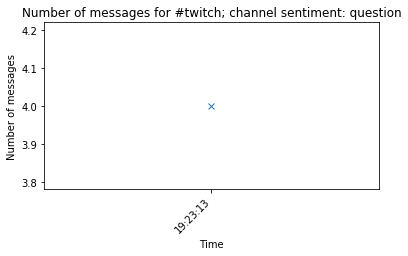

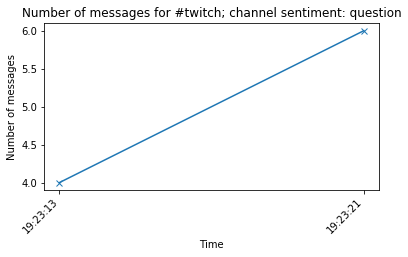

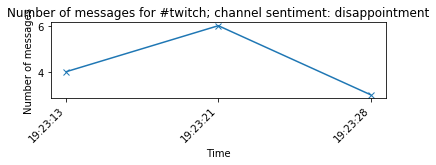

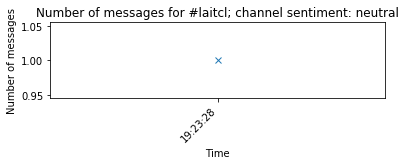

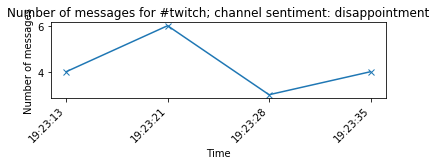

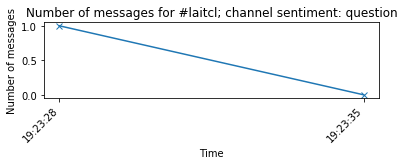

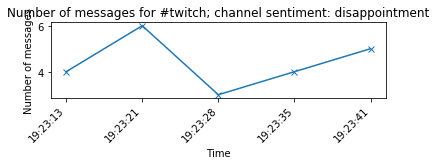

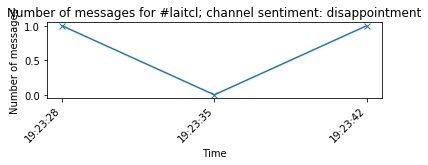

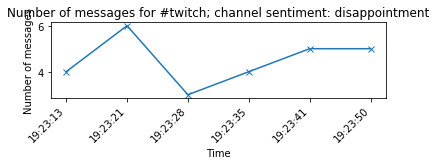

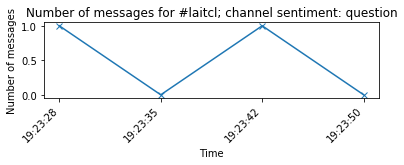

KeyboardInterrupt: 

In [4]:
if __name__ == '__main__':
    logfile = open("TwitchBot/messagelog.csv","r")
    #Setup tracking variables
    #For capturing data at set time intervalsmodel
    beginningtime=time.time()
    starttime = time.time()
    logtimeinterval = 5
    #For counting messages
    channelnumlines = {} 
    channelxs = {}
    channelys = {}
    #For intent classification
    channelsentiments = {}
    unique_intent = ['question', 'disappointment', 'funny', 'neutral']
    
    #begin logging chat
    loglines = followlog(logfile)
    for line in loglines:
        [date,timeofday,channel,text] = processline(line)
        if channel not in channelnumlines:
            #If channel wasn't previously tracked, start tracking
            [channelnumlines, channelys, channelxs] = initializenumlines(channel, channelnumlines, channelys, channelxs)
            channelsentiments[channel] = initializeintentcounter(unique_intent)
        channelsentiments[channel] = getmessagesentiment(channelsentiments[channel], word_tokenizer, text, model, max_length, unique_intent)#Increment a sentiment
        channelnumlines[channel] += 1#Increment the number of messages in that channel
        
        #Every interval, perform analysis
        if time.time() - starttime >= logtimeinterval:
            #clear_output()
            [channelnumlines, channelsentiments] = animatedplot(channelnumlines, channelxs, channelys, channelsentiments)#Plot the number of messages for each channel
            starttime = time.time()#Reset the start time    

In [6]:
#Export this notebook as a script
#!jupyter nbconvert --to script ChatProcessor.ipynb

[NbConvertApp] Converting notebook ChatProcessor.ipynb to script
[NbConvertApp] Writing 5870 bytes to ChatProcessor.py


In [2]:
import sys
print(sys.path)

['/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '', '/home/laitcl/.local/lib/python3.6/site-packages', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/home/laitcl/.local/lib/python3.6/site-packages/IPython/extensions', '/home/laitcl/.ipython']
